##First we have to install packages.

In [ ]:
!pip3 uninstall statsmodels

In [ ]:
!pip3 install numpy scipy patsy pandas

In [ ]:
!pip3 install statsmodels

In [ ]:
!pip install pmdarima

In [15]:
import pandas as pd
import glob
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
import statsmodels.api as sa

## Step 1: Load the dataset

In [16]:
df = pd.read_csv('https://raw.githubusercontent.com/Myloveismilk/bitcoin_price_prediction/main/data/btc_365.csv')

In [17]:
#See the first 5 rows of the dataset
df.head()

,date,open,high,low,close
0,2021-10-30,62253.70,62359.25,60673.00,61859.19
1,2021-10-31,61859.19,62405.30,59945.36,61299.80
2,2021-11-01,61299.81,62437.74,59405.00,60911.11
3,2021-11-02,60911.12,64270.00,60624.68,63219.99
4,2021-11-03,63220.57,63500.00,60382.76,62896.48


## Step 2: Drop, rename some columns and format their types.

In [26]:
df.dtypes

date     datetime64[ns]
open            float64
high            float64
low             float64
close           float64
dtype: object

In [27]:
df.shape

(365, 5)

In [29]:
from pmdarima.model_selection import train_test_split

train_data, test_data = train_test_split(df['close'], test_size = int(365 * 0.2))
test_data.shape, train_data.shape

((73,), (292,))

## Step 3: Handle Missings

In [30]:
df.shape

(365, 5)

In [31]:
df.isna().sum()

date     0
open     0
high     0
low      0
close    0
dtype: int64

## Step 4: Quick visualization

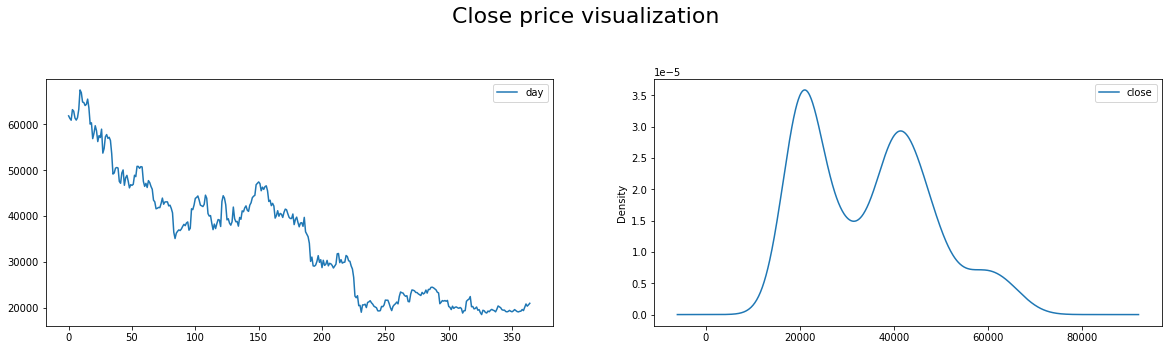

In [34]:
fig = plt.figure(figsize=[20, 10]);
plt.suptitle('Close price visualization', fontsize=22)

plt.subplot(221)
plt.plot(df['close'], '-', label= 'day');
plt.legend();

plt.subplot(222)
df['close'].plot(kind = 'kde');
plt.legend();

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['close'], model='multiplicative', period = 3)

<Figure size 432x288 with 0 Axes>

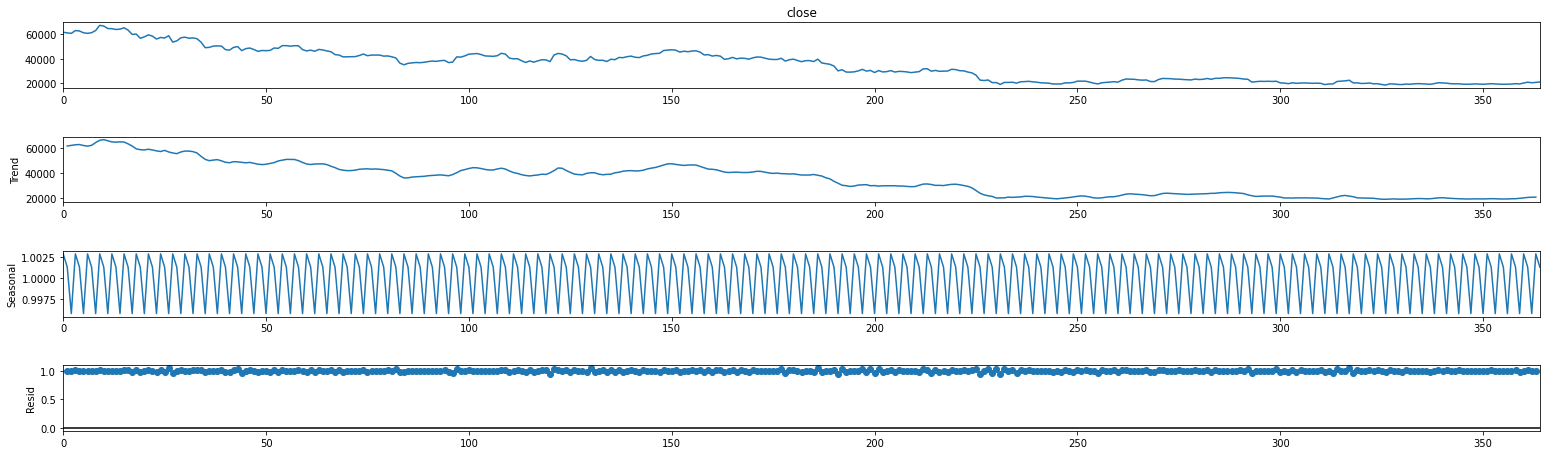

In [38]:
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(25, 7)

## Step 5: Stationarity test

In [39]:
from statsmodels.tsa.stattools import adfuller

In [40]:
# H0 : It is not stationary
# H1 : It is stationary
def adfuller_test(close_price):
  test_result = adfuller(close_price)
  labels = ['Test Statistic', 'p_value', 'Lag', 'Number of observations']
  for result, label in zip(test_result, labels):
    print(label + ' : ' + str(result))
  for key,value in test_result[4].items():
    print(f"critical value {key} :=  {value}")
  
adfuller_test(train_data)

Test Statistic : -1.5305155771349874
p_value : 0.518365359862936
Lag : 0
Number of observations : 291
critical value 1% :=  -3.4530232710482367
critical value 5% :=  -2.871523926671883
critical value 10% :=  -2.5720897694878424


We can see that the p_value is much greater than 0.05 and also the test statistic is greater than all critical values so the data is non-stationary.

In [41]:
df['seasonal_first_difference'] = train_data - train_data.shift(1)
df['seasonal_first_difference'][0:5]

0        NaN
1    -559.39
2    -388.69
3    2308.88
4    -323.51
Name: seasonal_first_difference, dtype: float64

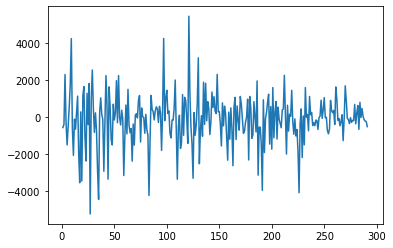

In [42]:
plt.plot(df['seasonal_first_difference'])

In [43]:
# Lets see the adf test result after differencing.
adfuller_test(df['seasonal_first_difference'].dropna())

Test Statistic : -16.94806070593657
p_value : 9.50703821073242e-30
Lag : 0
Number of observations : 290
critical value 1% :=  -3.453102162983312
critical value 5% :=  -2.871558538275452
critical value 10% :=  -2.5721082282996433


The p_value is now less than 0.05 so we can reject the NULL hypothesis and the data is now stationary

##Step 6: Identifying the order of AR and MA terms

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


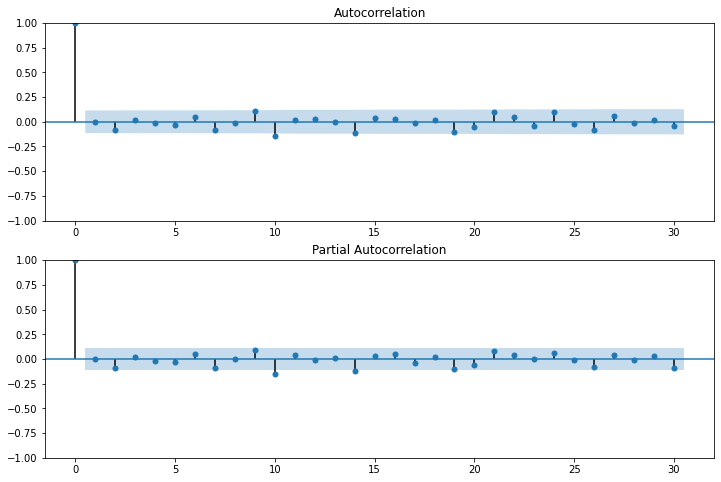

In [44]:
#Plot PACF & ACF chart
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['seasonal_first_difference'].dropna(),lags=30,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['seasonal_first_difference'].dropna(),lags=30,ax=ax2)

From the acf and pacf plot, we can see that both p and q are equal to 0.

##Step 7: Modeling

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.92 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5002.298, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4970.962, Time=0.51 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4963.437, Time=0.53 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5004.308, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=4947.503, Time=1.80 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4971.268, Time=0.32 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=4948.626, Time=6.45 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=4948.626, Time=7.22 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=4959.790, Time=1.67 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=4958.504, Time=2.32 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=4950.496, Time=9.49 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=4945.513, Time=1.63 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=4953.887, Time=0.67 sec
 ARIMA(0,1,0)(1,1,0)[12]

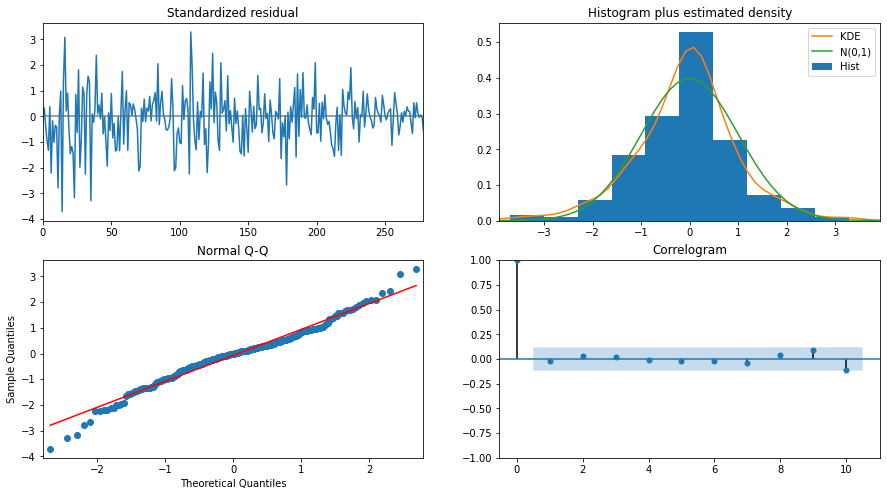

In [45]:
#Check the p and q value by using auto_arima

from pmdarima.arima import auto_arima
arima_model = auto_arima(train_data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True) 
print(arima_model.summary())
arima_model.plot_diagnostics(figsize=(15,8))
plt.show()

We are right, the p and q values stay the same.

In [49]:
model=sa.tsa.statespace.SARIMAX(train_data,order=(0, 1, 0),seasonal_order=(1,1,1,12))
results=model.fit()

In [50]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                close   No. Observations:                  292
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -2469.757
Date:                              Sat, 29 Oct 2022   AIC                           4945.513
Time:                                      09:17:41   BIC                           4956.407
Sample:                                           0   HQIC                          4949.883
                                              - 292                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.4547      0.035     12.917      0.000       0.386       0.524
ma.S.L12      -0.8341      0.047    -17.561      0.000      -0.927      -0.741
sigma2      2.745e+06   1.87e+05     14.689      0.000    2.38e+06    3.11e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                23.08
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
train_data.shape

(292,)

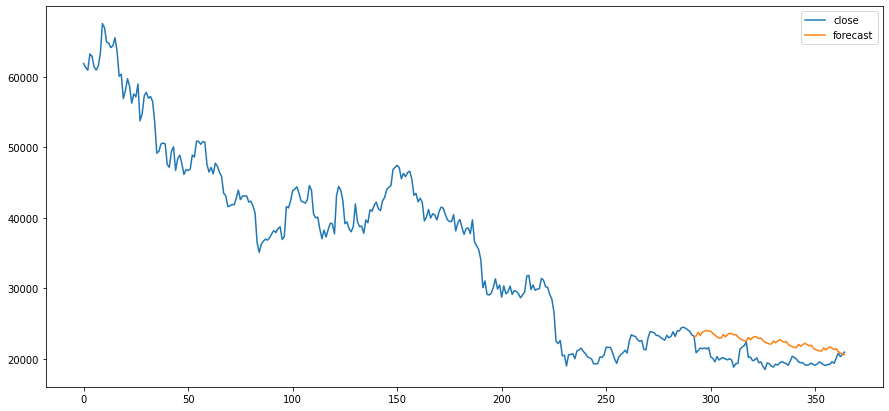

In [55]:
df['forecast'] = results.predict(start = 292, end = 292 + 73, dynamic = True)
df[['close','forecast']].plot(figsize=(15,7))

We see that in the first phase of the prediction, the orange line fit well to the actual line but the rest of the result of the test set, the prediction line still goes up and therefore it is not accurate.

In [56]:
#Score the prediction
y_pred = df['forecast'].dropna().reset_index(drop= True)
mse = mean_squared_error(test_data, y_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, y_pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, y_pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_pred - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))


MSE: 7352685.655168186
MAE: 2514.3171286312036
RMSE: 2711.5836065237204
MAPE: nan


Just by seeing the graph, we can say that this model is not good in predicting non-stationary data without an unit root, but it's still not bad :))